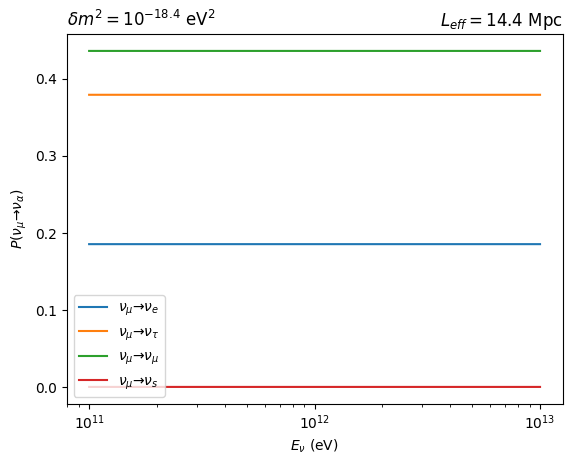

In [2]:
# REPRODUCING FIG. 2 (DONE)

import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib



# Norms for the PMNS matrix squared:

u_e = [0, 0.674743, 0.302844, 0.0224125]
u_m = [0, 0.0946105, 0.360415, 0.544974]
u_t = [0, 0.230646, 0.33674,  0.432613]


# Effective distance traveled in 1oeV:
l_eff = 4.4434e23 * 5.06773093741 * 1e6

# Mass-difference squared (under assumption that all flavors have the same mass difference) in eV^2:
del_m2 = 0 

# Energy dist:
a = np.logspace(11, 13, num=2000)


# cos squared term:
osc = (np.cos((del_m2 * l_eff)/(4*a)))**2


# Define start and end flavor states:
ui = u_m
uf1 = u_e
uf2 = u_t
uf3 = u_m


prob1 = osc * ((ui[1]*uf1[1]) + (ui[2]*uf1[2]) + (ui[3]*uf1[3]))
prob2 = osc * ((ui[1]*uf2[1]) + (ui[2]*uf2[2]) + (ui[3]*uf2[3]))
prob3 = osc * ((ui[1]*uf3[1]) + (ui[2]*uf3[2]) + (ui[3]*uf3[3]))
prob4 = 1 - prob1 - prob2 - prob3

fig1, ax1 = plt.subplots()
µe, = ax1.plot(a, prob1)
µτ, = ax1.plot(a, prob2)
µµ, = ax1.plot(a, prob3)
µs, = ax1.plot(a, prob4)
ax1.set_xscale('log')
ax1.set_xticks([10**11, 10**12, 10**13])
ax1.set_xlabel(r"$E_{\nu}$ (eV)")
ax1.set_ylabel(r"$P(\nu_{\mu} \to \nu_{\alpha})$")
ax1.set_title(r"$\delta m^2 = 10^{-18.4}$ eV$^2$", loc="left")
ax1.set_title(r"$L_{eff} = 14.4$ Mpc", loc="right")
ax1.legend([µe, µτ, µµ, µs], [r"$\nu_{\mu} \to \nu_{e}$", r"$\nu_{\mu} \to \nu_{\tau}$",r"$\nu_{\mu} \to \nu_{\mu}$",r"$\nu_{\mu} \to \nu_{s}$"])
plt.show()


         energy
0      0.100000
1      0.112202
2      0.125893
3      0.141254
4      0.158489
..          ...
76   630.957344
77   707.945784
78   794.328235
79   891.250938
80  1000.000000

[81 rows x 1 columns]


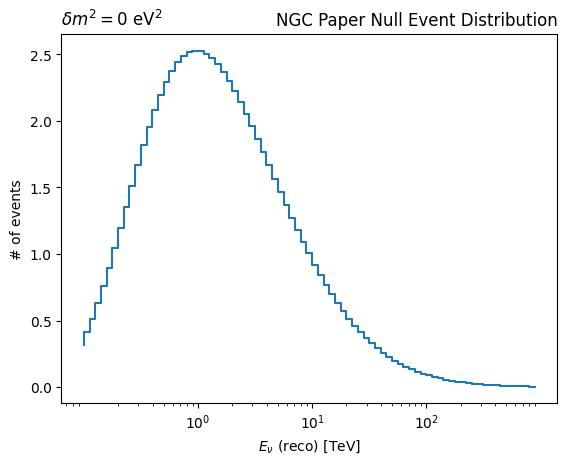

In [129]:
# PLOTTING FIG. 3 (DONE)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

hypotheses = pd.read_csv('hypotheses.csv')
bin_edges = pd.read_csv('bin_edges.csv')

hypotheses.columns = ['null', 'alt_1', 'alt_2']
bin_edges.columns = ['energy']

frames = [bin_edges, hypotheses]

chart = pd.concat(frames, axis=1)

print(bin_edges)

fig, ax = plt.subplots()
null = ax.step(chart['energy'], chart['null'])
# alt_1 = ax.step(chart['energy'], chart['alt_1'])
# alt_2 = ax.step(chart['energy'], chart['alt_2'])
ax.set_xscale('log')
ax.set_xticks([10**0, 10**1, 10**2])
ax.set_xlabel(r"$E_{\nu}$ (reco) [TeV]")
ax.set_ylabel(r"# of events")
ax.set_title(r"$\delta m^2 = 0$ eV$^2$", loc="left")
ax.set_title("NGC Paper Null Event Distribution", loc='right')

plt.show()




In [4]:
# REPRODUCING TS VALUES (DONE)

from scipy.stats import poisson
import math


def Poissonlog(data, hyp):
    return np.log((hyp**data)*np.exp(-hyp)/math.gamma(data + 1))

summand_alt1, summand_alt2 = np.zeros((len(hypotheses.index))), np.zeros((len(hypotheses.index)))


for i in range(len(hypotheses.index)):
    summand_alt1[i] = Poissonlog(hypotheses['null'][i], hypotheses['alt_1'][i]) - Poissonlog(hypotheses['null'][i], hypotheses['null'][i])
    summand_alt2[i] = Poissonlog(hypotheses['null'][i], hypotheses['alt_2'][i]) - Poissonlog(hypotheses['null'][i], hypotheses['null'][i])

ts_alt1, ts_alt2 = -2*sum(summand_alt1), -2*sum(summand_alt2)

print(f"TS alt 1: {ts_alt1}, TS alt 2: {ts_alt2}")

TS alt 1: 29.9567946015047, TS alt 2: 2.882064924813901


In [123]:
# ATTEMPTING TO REPRODUCE FIG. 3 (IN PROGRESS)

from scipy.stats import norm
from scipy.integrate import quad

# want norm.pdf(e_t, e_reco, width)

eff_a = np.loadtxt('effA_-5to30.dat')

# Let's go always from E_min = 10^-1 TeV to E_max = 7.94328*10^5 TeV (gotten from limits of effA_-5to30.dat values)
e_min = 1e-1
e_max = 7.94328e5

# We want the number of mu and tau neutrinos (maybe not tau but definitely mu)
# All following calculations are just for mu neutrinots

# Parameters:
phi0 = 5e-11 * 275270400 # TeV^-1 cm^-2 s^-1 times 3168 days
e0 = 1 # TeV
index = 3.2 # Taken from NGC paper
width = 0.3 # Taken from the 30% energy resolution of track-like events


# We first integrate over true energy:

# defining the integrand (gauss weight * flux * effective area * probability of being mu)
def TrueIntegrand(e_true, e_reco, del_m2):
    flux = (e_true/e0)**(-index)
    # print(f"flux: {flux}")
    # gauss = norm.pdf(e_true, e_reco, 0.3)
    log_gauss = norm.pdf(np.log(e_true), np.log(e_reco), 0.3)
    # print(f"gauss: {gauss}")
    
    # Finding the appropriate effective energy for the given true energy
    arg = e_true - eff_a[:,0]
    for i in range(len(arg)):
        if arg[i] < 0:
            arg[i] = 1e6
    effa = 10000*eff_a[arg.argmin()][4] # cm^2, in data set as m^2
    # print(f"effective area: {effa}")

    # Calculating probability that the neutrino will be a mu neutrino (change e_true to eV): 
    osc = (np.cos((del_m2 * l_eff)/(4*e_true*1e12)))**2

    prob_surv = osc * ((u_m[1]*u_m[1]) + (u_m[2]*u_m[2]) + (u_m[3]*u_m[3]))
    prob_emu = osc * ((u_e[1]*u_m[1]) + (u_e[2]*u_m[2]) + (u_e[3]*u_m[3]))

    prob_mu = 0.666666*prob_surv + 0.333333*prob_emu # I'm getting this from the assumed 1:2:0 e-mu-tau flavor distribution at the source, so I'm weighting the corresponding probabilities accordingly
    # print(f"prob of being mu: {prob_mu}")
    # integrand = gauss*flux*effa*prob_mu
    log_integrand = (1/(e_true*np.log(10)))*log_gauss*flux*effa*prob_mu
    return log_integrand


# Do the integration (limiting bounds of integration to \pm 5*width)
def RecoIntegrand(e_reco, del_m2):
    true_int = quad(TrueIntegrand, max(e_min, e_reco-5*np.power(10, 0.3)), min(e_max, e_reco+5*np.power(10, 0.3)), args=(e_reco, del_m2, ), epsabs=0.5)
    return phi0*true_int[0]

test = RecoIntegrand(11, 0)
print(test)


# Not integrating over energy bins yet because it's taking really long to run as is, like 20 secs for the following chart




0.1096637736912374


/var/folders/f1/m1ggk_2j6sg3vl8gbd6xc_080000gn/T/ipykernel_1473/573819152.py:57: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  true_int = quad(TrueIntegrand, max(e_min, e_reco-5*np.power(10, 0.3)), min(e_max, e_reco+5*np.power(10, 0.3)), args=(e_reco, del_m2, ), epsabs=0.5)


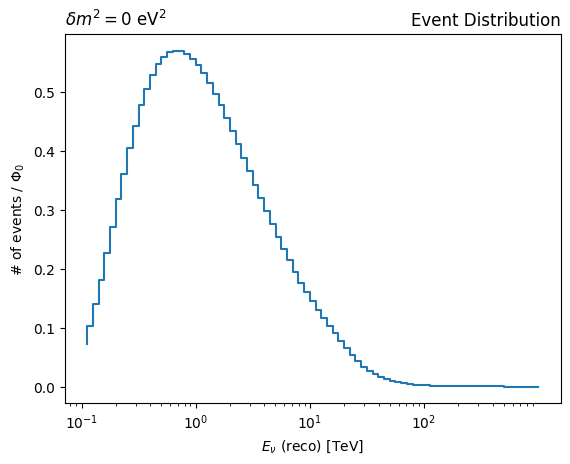

In [124]:
# Trying to calculate the final integral

bins, avg_recoint = np.zeros((len(chart['energy']))), np.zeros((len(chart['energy'])))
for i in range(len(chart['energy'])):
    bins[i] = chart['energy'][i]
for i in range(len(chart['energy'])-1):
    avg_recoint[i] = RecoIntegrand(bins[i], 0)*(bins[i+1]-bins[i])

fig, ax = plt.subplots()
hyp_178, = ax.step(bins, avg_recoint)
ax.set_xscale('log')
ax.set_xticks([10**-1, 10**0, 10**1, 10**2])
ax.set_xlabel(r"$E_{\nu}$ (reco) [TeV]")
ax.set_ylabel(r"# of events / $\Phi_0$")
ax.set_title(r"$\delta m^2 = 0$ eV$^2$", loc="left")
ax.set_title(r"Event Distribution", loc="right")
plt.show()









0.13880376729742308


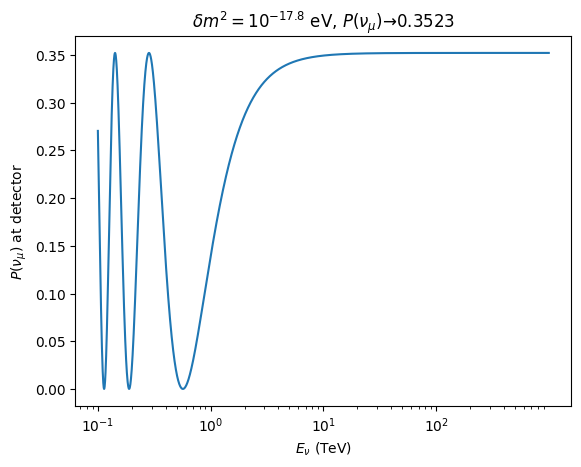

In [127]:
# Plotting probability of being mu neutrino at detector:

del_m2 = 10**(-17.8)

osc_test = (np.cos((del_m2 * l_eff)/(4*(10**0)*1e12)))**2
prob_surv_test = osc_test * ((u_m[1]*u_m[1]) + (u_m[2]*u_m[2]) + (u_m[3]*u_m[3]))
prob_emu_test = osc_test * ((u_e[1]*u_m[1]) + (u_e[2]*u_m[2]) + (u_e[3]*u_m[3]))
prob_mu_test = 0.666666666*prob_surv_test + 0.333333333*prob_emu_test
print(prob_mu_test)

a = np.logspace(-1, 3, 3000)

osc = (np.cos((del_m2 * l_eff)/(4*a*1e12)))**2

prob_surv = osc * ((u_m[1]*u_m[1]) + (u_m[2]*u_m[2]) + (u_m[3]*u_m[3]))
prob_emu = osc * ((u_e[1]*u_m[1]) + (u_e[2]*u_m[2]) + (u_e[3]*u_m[3]))

prob_mu = 0.666666*prob_surv + 0.333333*prob_emu

fig, ax = plt.subplots()
delm_178 = ax.plot(a, prob_mu)
ax.set_xscale('log')
ax.set_xticks([10**-1, 10**0, 10**1, 10**2])
ax.set_xlabel(r"$E_{\nu}$ (TeV)")
ax.set_ylabel(r"$P(\nu_{\mu})$ at detector")
ax.set_title(r"$\delta m^2 = 10^{-17.8}$ eV, $P(\nu_{\mu}) \to 0.3523$")
plt.show()


/var/folders/f1/m1ggk_2j6sg3vl8gbd6xc_080000gn/T/ipykernel_1473/3065745400.py:57: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  true_int = quad(TrueIntegrand, max(e_min, e_reco-np.exp(1.5)), min(e_max, e_reco+np.exp(1.5)), args=(e_reco, del_m2, ), epsabs=0.5)


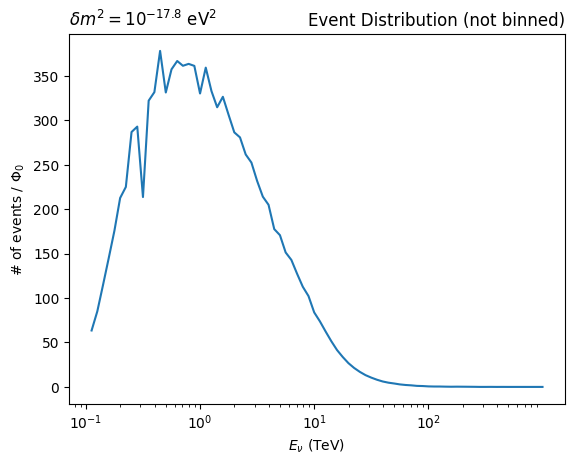

In [8]:
# Plotting just one PD scenario

array_178 = np.zeros((len(chart['energy'])))
for i in range(len(chart['energy'])):
    array_178[i] = RecoIntegrand(chart['energy'][i], 10**(-14))
fig, ax = plt.subplots()
hyp_178, = ax.plot(chart['energy'], array_178)
ax.set_xscale('log')
ax.set_xticks([10**-1, 10**0, 10**1, 10**2])
ax.set_xlabel(r"$E_{\nu}$ (TeV)")
ax.set_ylabel(r"# of events / $\Phi_0$")
ax.set_title(r"$\delta m^2 = 10^{-17.8}$ eV$^2$", loc="left")
ax.set_title(r"Event Distribution (not binned)", loc="right")
plt.show()

/var/folders/f1/m1ggk_2j6sg3vl8gbd6xc_080000gn/T/ipykernel_1473/222951581.py:58: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  true_int = quad(TrueIntegrand, max(e_min, e_reco-5*np.exp(0.3)), min(e_max, e_reco+5*np.exp(0.3)), args=(e_reco, del_m2, ), epsabs=0.5)


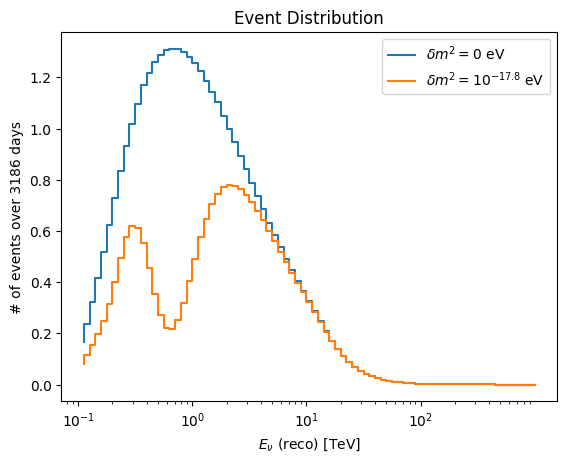

In [106]:
# Plotting many PD scenarios
bins = np.zeros((len(chart['energy'])))
for i in range(len(chart['energy'])):
    bins[i] = chart['energy'][i]

array_null, array_172, array_178, array_184 = np.zeros((len(chart['energy']))), np.zeros((len(chart['energy']))), np.zeros((len(chart['energy']))), np.zeros((len(chart['energy'])))

for i in range(len(chart['energy'])-1):
    array_null[i] = RecoIntegrand(bins[i], 0)*(bins[i+1]-bins[i])
    array_172[i] = RecoIntegrand(bins[i], 10**(-17.7))*(bins[i+1]-bins[i])
    array_178[i] = RecoIntegrand(bins[i], 10**(-17.8))*(bins[i+1]-bins[i])
    array_184[i] = RecoIntegrand(bins[i], 10**(-17.9))*(bins[i+1]-bins[i])

fig, ax = plt.subplots()
hyp_null, = ax.step(bins, array_null)
# hyp_172, = ax.step(bins, array_172)
hyp_178, = ax.step(bins, array_178)
# hyp_184, = ax.step(bins, array_184)
ax.set_xscale('log')
ax.set_xticks([10**-1, 10**0, 10**1, 10**2])

ax.set_xlabel(r"$E_{\nu}$ (reco) [TeV]")
ax.set_ylabel(r"# of events over 3186 days")
# ax.set_title(r"$\delta m^2 = 10^{-17.72}$ eV$^2$", loc="left")
ax.set_title(r"Event Distribution", loc="center")
ax.legend([hyp_null, hyp_178], [r"$\delta m^2 = 0$ eV", r"$\delta m^2 = 10^{-17.8}$ eV"])

plt.show()